In [2]:
## Import Python libraries ## 

import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import xarray as xr


%matplotlib inline
%reload_ext xsimlab.ipython


import fastscape

from orographic_precipitation.fastscape_ext import precip_model
from fastscape.processes import Bedrock

In [3]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


In [4]:
## Build xarray-simlab model ##
SouthernAndesLEM = precip_model
SouthernAndesLEM = precip_model.drop_processes(['init_topography'])
SouthernAndesLEM = SouthernAndesLEM.update_processes({'bedrock': Bedrock})

SouthernAndesLEM

<xsimlab.Model (17 processes, 26 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
surf2erode
init_erosion
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] () or ('y', 'x') background, non-or...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time              [in] fallout time
    nm                     [in] moist stability frequ

In [5]:
## Model dimensions/grid dimensions ##
nx = 100
ny = 100
nn = nx * ny

xl = 100.e3
yl = 100.e3

BoundaryCondition = ['looped', 'looped', 'fixed_value', 'fixed_value']

## Model time and time stepping ##
EndTime_1 = 5e6
EndTime_2 = 5e6
EndTime_3 = 8e6
TimeSteps_1 = 10001
TimeSteps_2 = 10001
TimeSteps_3 = 16001

# EndTime = 1e6
# TimeSteps = 1001
ModelTime_1 = np.linspace(0., EndTime_1, TimeSteps_1)
ModelTime_2 = np.linspace(0., EndTime_2, TimeSteps_2)
ModelTime_3 = np.linspace(0., EndTime_3, TimeSteps_3)

PlotStep = 100

## Tectonics ##
k_coef= 2.5e-5
area_exp = 0.4
slope_exp = 1.0
diffusion_diffusivity = 0.


## Orographic ##
lapse_rate = -5.4 #mean lapse rate of area not too far away 
lapse_rate_m = -6.5 #left default
ref_density = 7.4e-3  #left default
rainfall_frequency = 5 #could not find high resolution data for hourly rainfall in the area of patagonia i was interested in looking at so just and estimate
latitude = 46  #latitude around the area north in the Patagonian Andes
precip_base =  1e-4 #not sure if I should change this or not
wind_speed = 10 #base to start with 
wind_dir = 270  # estimated direction given weather info 
precip_min = 0.1 #chatgpt value so could be wrong
conv_time = 2000 #2000 thesis value
fall_time = 2000 #2000 thesis value
nm = 0.003  #0.03 #thesis value
hw = 5000  #


## Initial topography ##
WhiteNoiseLevel = 50 # in [m], amplitude of noise

## Seed for Reproducibility ##
RandomSeed = 1410

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid size
nx, ny = 100, 100  # Example values; adjust as needed
nn = nx * ny  # Total number of nodes

# Initialize an array to store elevations
InitialTopography = np.zeros(nn)

# Assign elevations based on node indices (using slicing and grid structure)
InitialTopography[:int(0.25 * nn)] = 400    # First 25% of nodes
InitialTopography[int(0.25 * nn):int(0.5 * nn)] = 3375  # Next 25% of nodes
InitialTopography[int(0.5 * nn):int(0.75 * nn)] = 2500  # Next 25% of nodes
InitialTopography[int(0.75 * nn):] = 1000  # Last 25% of nodes

# Adding random noise to the elevations
np.random.seed(42)  # For reproducibility
WhiteNoiseLevel = 50  # Standard deviation of noise
Noise = np.random.normal(0, WhiteNoiseLevel, nn)
InitialTopography += Noise  # Add noise to the elevations

# Reshape the 1D array to 2D with shape (ny, nx)
InitialTopography_2D = InitialTopography.reshape((ny, nx))

# Define first stage uplift rates for each region
UpliftRates = np.zeros(nn)  # Initialize uplift rates array

# Assign uplift rates to regions (using slicing or fractions of the total nodes)
UpliftRates[:int(0.25 * nn)] = 0.01    # First 25% of nodes
UpliftRates[int(0.25 * nn):int(0.5 * nn)] = 0.041  # Next 25% of nodes
UpliftRates[int(0.5 * nn):int(0.75 * nn)] = 0.035  # Next 25% of nodes
UpliftRates[int(0.75 * nn):] = 0.02  # Last 25% of nodes

# Adding random noise to the uplift rates for realism (optional)
np.random.seed(42)  # For reproducibility
UpliftNoise = np.random.normal(0, 0.005, nn)  # Small noise in uplift rates
UpliftRates += UpliftNoise  # Add noise to the uplift rates

# Reshape the 1D array to 2D with shape (ny, nx)
UpliftRates_2D = UpliftRates.reshape((ny, nx))

# Rotate both topography and uplift rates 90 degrees anti-clockwise
RotatedTopography_2D = np.rot90(InitialTopography_2D, k=1)
RotatedUpliftRates_2D = np.rot90(UpliftRates_2D, k=1)

In [10]:
import os
import numpy as np
import xsimlab as xs

# Directory to save Zarr files
output_dir = "simulation_outputs"
os.makedirs(output_dir, exist_ok=True)

# Define nm values to test
nm_values = np.concatenate((np.linspace(0, 0.01, 10), np.linspace(0.003, 0.004, 5)))

# Time steps to visualize
time_indices = [0, 1, 10, 100, 1000, 10000]
mean_elevations = []

# Loop through lapse_rate and nm values and run simulations
for nm in nm_values:
        print(f"Running simulation for nm = {nm}")
        
        # Set up the model with the current lapse_rate and nm
        in_ds_lapse = xs.create_setup(
            model=SouthernAndesLEM,
            clocks={
                'time': ModelTime_1,
                'output': ModelTime_1[::PlotStep]
            },
            master_clock='time',
            input_vars={
                'grid': {'shape': [nx, ny], 'length': [xl, yl]},
                'boundary': {'status': BoundaryCondition},
                'topography': {'elevation': RotatedTopography_2D},
                'bedrock': {'elevation': RotatedTopography_2D},
                'uplift': {'rate': RotatedUpliftRates_2D},
                'spl': {'k_coef': k_coef, 'area_exp': area_exp, 'slope_exp': slope_exp},
                'diffusion': {'diffusivity': diffusion_diffusivity},
                'orographic': {
                    'lapse_rate': lapse_rate,
                    'lapse_rate_m': lapse_rate_m,
                    'ref_density': ref_density,
                    'rainfall_frequency': rainfall_frequency,
                    'latitude': latitude,
                    'precip_base': precip_base,
                    'wind_speed': wind_speed,
                    'wind_dir': wind_dir,
                    'precip_min': precip_min,
                    'conv_time': conv_time,
                    'fall_time': fall_time,
                    'nm': nm,  # Change nm here
                    'hw': hw,
                },
            },
            output_vars={'topography__elevation': 'time', 'orographic__precip_rate': 'time'}
        )

        # Run the simulation
        with xs.monitoring.ProgressBar():
            out_ds_lapse = in_ds_lapse.xsimlab.run(model=SouthernAndesLEM)
        
        # Store simulation results in Zarr format
        zarr_filename = os.path.join(output_dir, f"simulation_nm_{nm:.5f}.zarr")
        out_ds_lapse.to_zarr(zarr_filename, mode='w')
        print(f"Saved results for nm = {nm} to {zarr_filename}")


Running simulation for nm = 0.0


             0% | initialize 

Saved results for nm = 0.0 to simulation_outputs/simulation_nm_0.00000.zarr
Running simulation for nm = 0.0011111111111111111


             0% | initialize 

Saved results for nm = 0.0011111111111111111 to simulation_outputs/simulation_nm_0.00111.zarr
Running simulation for nm = 0.0022222222222222222


             0% | initialize 

Saved results for nm = 0.0022222222222222222 to simulation_outputs/simulation_nm_0.00222.zarr
Running simulation for nm = 0.003333333333333333


             0% | initialize 

Saved results for nm = 0.003333333333333333 to simulation_outputs/simulation_nm_0.00333.zarr
Running simulation for nm = 0.0044444444444444444


             0% | initialize 

Saved results for nm = 0.0044444444444444444 to simulation_outputs/simulation_nm_0.00444.zarr
Running simulation for nm = 0.005555555555555556


             0% | initialize 

Saved results for nm = 0.005555555555555556 to simulation_outputs/simulation_nm_0.00556.zarr
Running simulation for nm = 0.006666666666666666


             0% | initialize 

Saved results for nm = 0.006666666666666666 to simulation_outputs/simulation_nm_0.00667.zarr
Running simulation for nm = 0.0077777777777777776


             0% | initialize 

Saved results for nm = 0.0077777777777777776 to simulation_outputs/simulation_nm_0.00778.zarr
Running simulation for nm = 0.008888888888888889


             0% | initialize 

Saved results for nm = 0.008888888888888889 to simulation_outputs/simulation_nm_0.00889.zarr
Running simulation for nm = 0.01


             0% | initialize 

Saved results for nm = 0.01 to simulation_outputs/simulation_nm_0.01000.zarr
Running simulation for nm = 0.003


             0% | initialize 

Saved results for nm = 0.003 to simulation_outputs/simulation_nm_0.00300.zarr
Running simulation for nm = 0.0032500000000000003


             0% | initialize 

Saved results for nm = 0.0032500000000000003 to simulation_outputs/simulation_nm_0.00325.zarr
Running simulation for nm = 0.0035


             0% | initialize 

Saved results for nm = 0.0035 to simulation_outputs/simulation_nm_0.00350.zarr
Running simulation for nm = 0.00375


             0% | initialize 

Saved results for nm = 0.00375 to simulation_outputs/simulation_nm_0.00375.zarr
Running simulation for nm = 0.004


             0% | initialize 

Saved results for nm = 0.004 to simulation_outputs/simulation_nm_0.00400.zarr


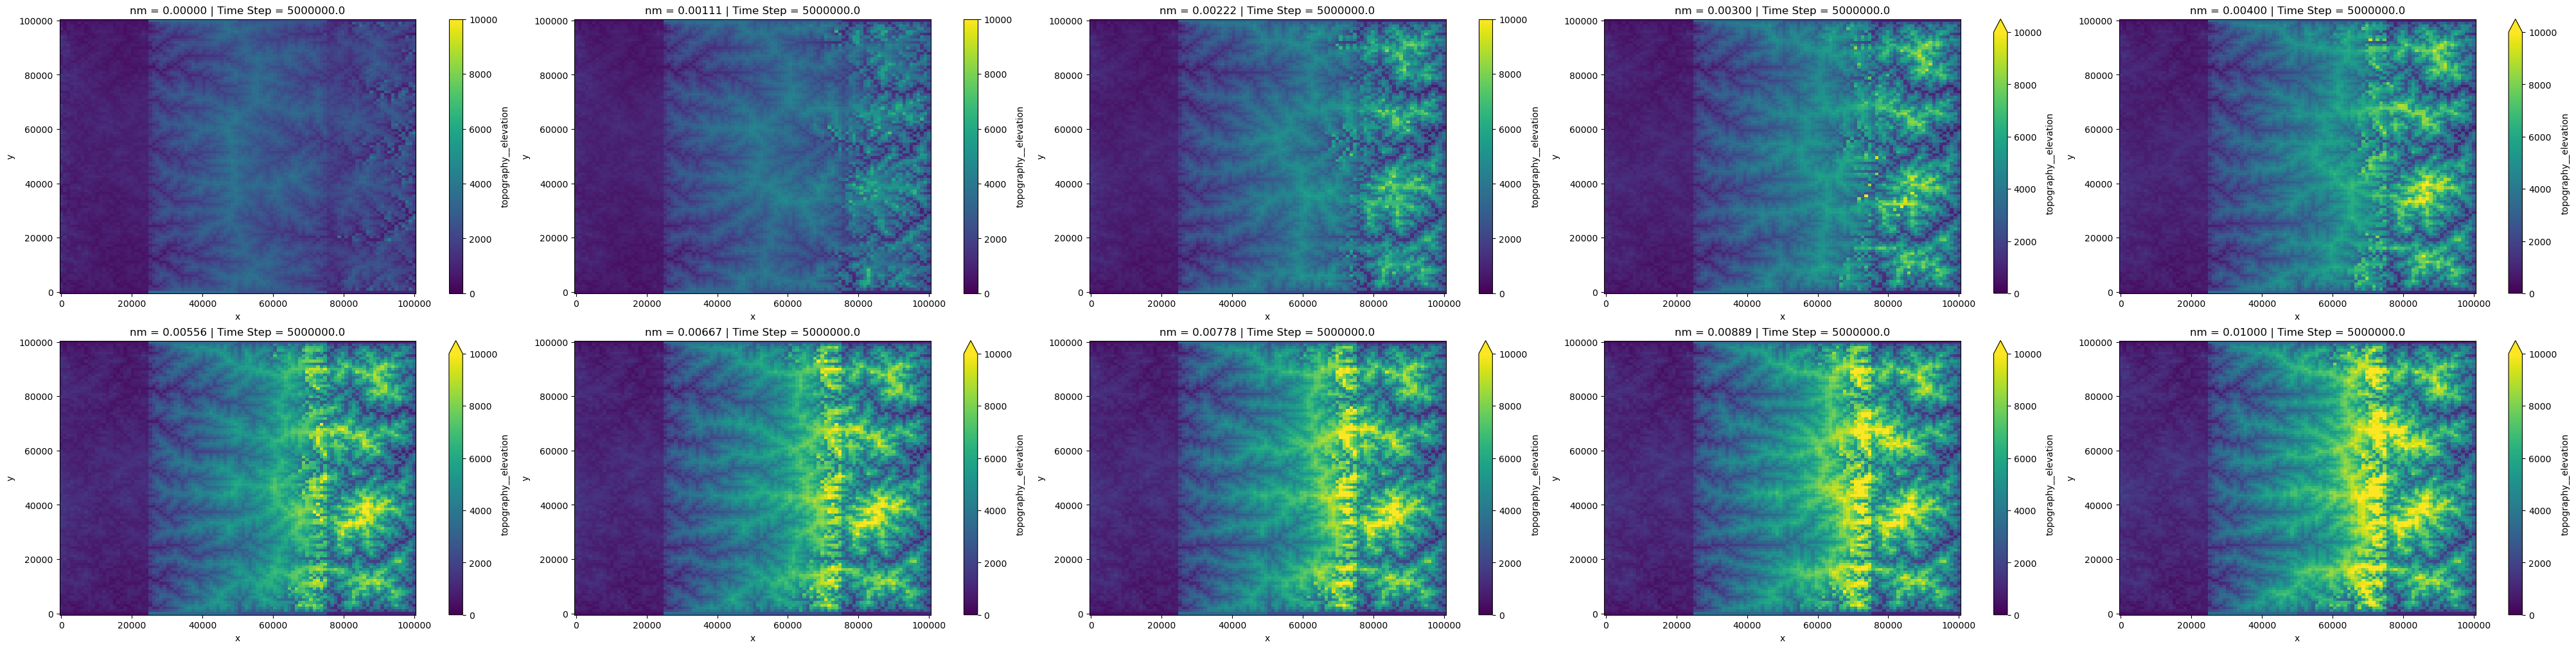

In [14]:
import os
import numpy as np
import xarray as xr
import hvplot.xarray  # For interactive plotting
import matplotlib.pyplot as plt
import dask

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by nm value
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_nm_") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_nm_")[-1][:-5]))

# Specify the nm values you want to plot
desired_nm_values = [0., 0.00111, 0.00222, 0.003, 0.004, 0.00556, 0.00667, 0.00778, 0.00889, 0.01]

# Load datasets and attach nm as a coordinate
datasets = []
nm_values = []  # This will hold the filtered nm values
time_steps = []
for zarr_file in zarr_files:
    nm_value = float(zarr_file.split("_nm_")[-1][:-5])  # Extract nm value from filename
    if nm_value in desired_nm_values:  # Filter based on the desired nm values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add nm as a coordinate
        ds = ds.assign_coords(nm=nm_value)
        
        datasets.append(ds)
        nm_values.append(nm_value)  # Append only the desired nm values
        
        # Extract the time step (assuming 'time' is a coordinate)
        time_steps.append(ds.time.values[-1])  # Get the last time step value

# Concatenate datasets along the new nm dimension
combined_ds = xr.concat(datasets, dim="nm")

# Ensure nm is a dimension and coordinate
combined_ds = combined_ds.sortby("nm")

# Calculate the number of rows and columns based on the number of nm values
num_plots = len(nm_values)
num_cols = (num_plots + 1) // 2  # Number of columns (2 per row)
num_rows = (num_plots + num_cols - 1) // num_cols  # Ensure we cover all plots

# 📌 Plot: Elevation Maps for Selected nm Values at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)  # Increased width
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, nm_value, time_step in zip(axes, datasets, nm_values, time_steps):
    ds.topography__elevation.isel(time=-1).plot(ax=ax, vmin=0, vmax=10000, cmap='viridis')
    ax.set_title(f"nm = {nm_value:.5f} | Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Hide any unused subplots
for i in range(len(nm_values), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Elevation_nm_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()

Available nm values in dataset: [0.      0.00111 0.00222 0.003   0.00325 0.00333 0.0035  0.00375 0.004
 0.00444 0.00556 0.00667 0.00778 0.00889 0.01   ]


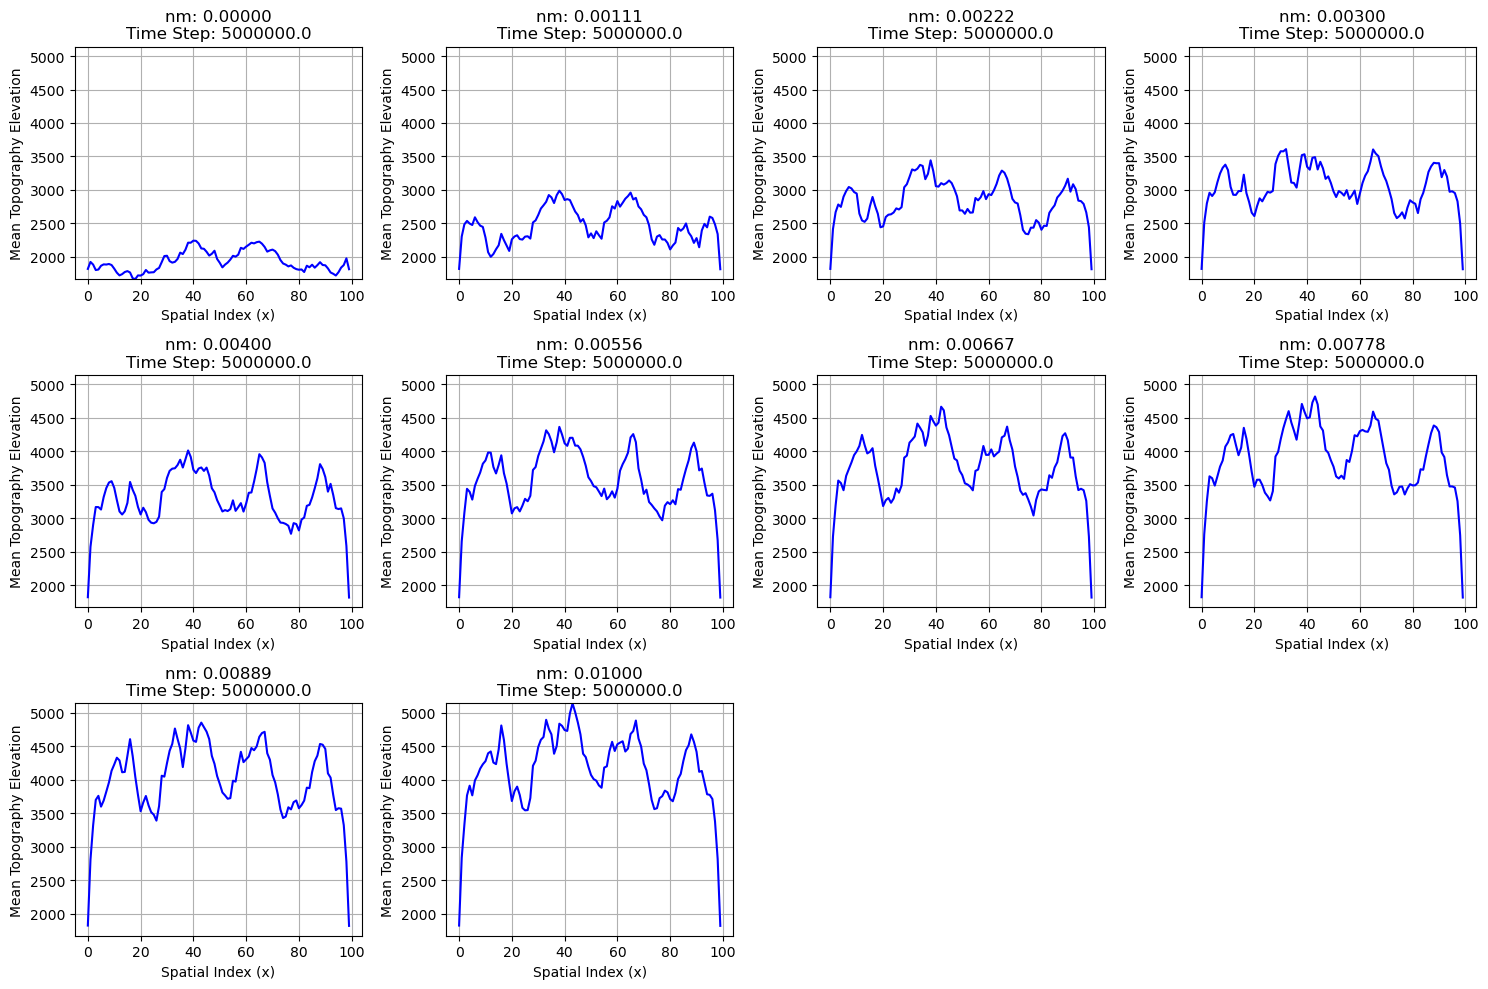

In [15]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by nm values
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_nm_") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_nm_")[-1][:-5]))  # Extract and sort nm values

# Define the nm values to plot
desired_nm_values = [0., 0.00111, 0.00222, 0.003, 0.004, 0.00556, 0.00667, 0.00778, 0.00889, 0.01]

# Load datasets and attach nm as a coordinate
datasets = []
nm_values = []

for zarr_file in zarr_files:
    nm_value = float(zarr_file.split("_nm_")[-1][:-5])  # Extract nm value from filename
    ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
    
    # Add nm as a coordinate
    ds = ds.assign_coords(nm=nm_value)
    
    datasets.append(ds)
    nm_values.append(nm_value)

# Concatenate datasets along the new nm dimension
combined_ds = xr.concat(datasets, dim="nm")

# Ensure nm is a dimension and coordinate
combined_ds = combined_ds.sortby("nm")

# Print available values for debugging
print("Available nm values in dataset:", combined_ds.nm.values)

# Fix: Use nearest selection for valid nm values
valid_nm_values = []
for nm in desired_nm_values:
    try:
        elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(nm=nm, method="nearest").mean(dim='x')
        valid_nm_values.append(nm)
    except KeyError:
        print(f"Skipping {nm}: No matching data found.")

# Adjust number of rows and columns based on valid nm values
n_valid = len(valid_nm_values)
ncols = 4  # Define number of columns
nrows = (n_valid // ncols) + (1 if n_valid % ncols != 0 else 0)  # Calculate rows needed

# Create subplots dynamically based on valid nm values
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axes = axes.flatten()

# Initialize variables to track global min and max for consistent y-axis scaling
global_min_elevation = np.inf
global_max_elevation = -np.inf

# First, loop to find the global min and max of the mean topography elevations
for nm in valid_nm_values:
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(nm=nm, method="nearest").mean(dim='x')
    global_min_elevation = min(global_min_elevation, elevation_data.min())
    global_max_elevation = max(global_max_elevation, elevation_data.max())

# Plot only for valid nm values
for idx, nm in enumerate(valid_nm_values):
    ax = axes[idx]
    time_step = str(combined_ds.time[-1].values)  # Extract the last time step value
    title = f"nm: {nm:.5f}\nTime Step: {time_step}"
    
    # Get the mean elevation for this nm at the last time step
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(nm=nm, method="nearest").mean(dim='x')
    
    # Plot the elevation data as a line plot
    ax.plot(elevation_data, label='Mean Topography Elevation', color='blue')
    
    ax.set_title(title)
    ax.set_ylabel("Mean Topography Elevation")
    ax.set_xlabel("Spatial Index (x)")
    ax.set_ylim(global_min_elevation, global_max_elevation)
    ax.grid(True)

# Hide unused axes
for ax in axes[len(valid_nm_values):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


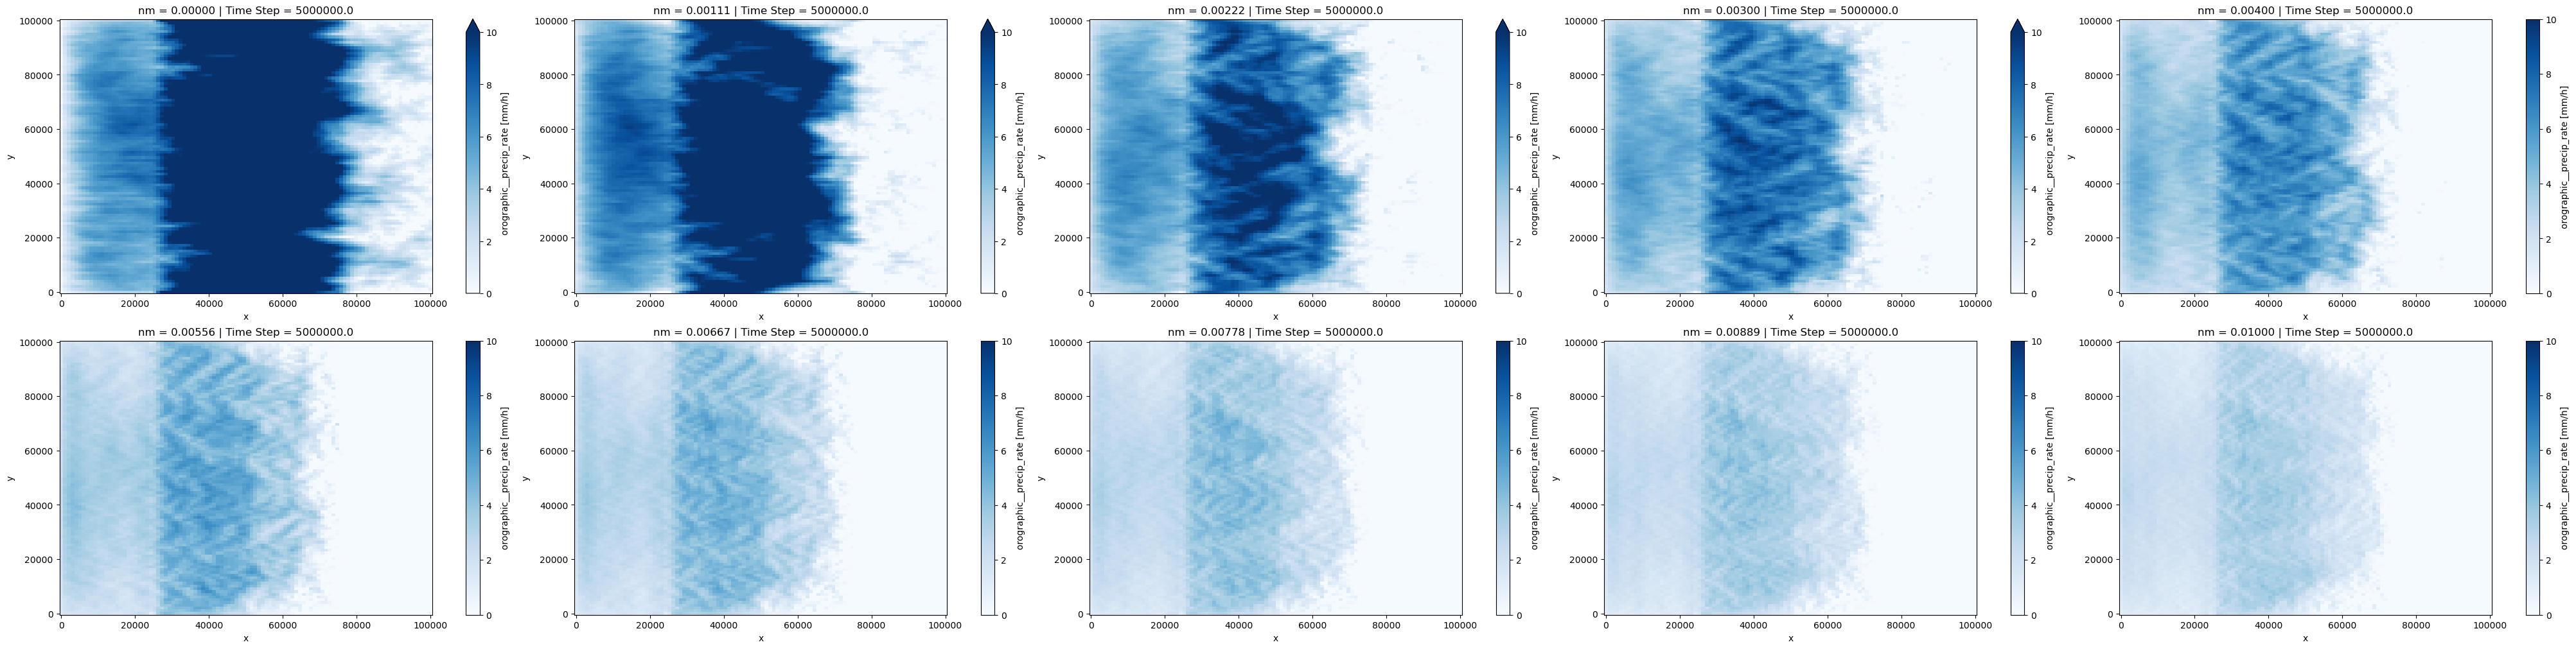

In [17]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by nm values
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_nm_") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_nm_")[-1][:-5]))  # Extract and sort nm values

# Define specific nm values to plot
desired_nm_values = [0., 0.00111, 0.00222, 0.003, 0.004, 0.00556, 0.00667, 0.00778, 0.00889, 0.01]  # Adjust based on your simulations

# Load datasets and attach nm as a coordinate
datasets = []
nm_values = []
time_steps = []

for zarr_file in zarr_files:
    nm_value = float(zarr_file.split("_nm_")[-1][:-5])  # Extract value
    if nm_value in desired_nm_values:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add nm as a coordinate
        ds = ds.assign_coords(nm=nm_value)
        
        datasets.append(ds)
        nm_values.append(nm_value)  # Append only desired values
        
        # Extract the last time step
        time_steps.append(ds.time.values[-1])

# Concatenate datasets along the new nm dimension
combined_ds = xr.concat(datasets, dim="nm")
combined_ds = combined_ds.sortby("nm")  # Ensure correct order

# Calculate grid layout for subplots
num_plots = len(nm_values)
num_cols = (num_plots + 1) // 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# 📌 Plot: Precipitation Maps for Selected nm Values at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, nm_value, time_step in zip(axes, datasets, nm_values, time_steps):
    # Plot precipitation at the final time step
    precip_data = ds.orographic__precip_rate.isel(time=-1)
    precip_data.plot(ax=ax, vmin=0, vmax=10, cmap='Blues')
    ax.set_title(f"nm = {nm_value:.5f} | Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Hide any unused subplots
for i in range(len(nm_values), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Precipitation_Nm_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()
